### Imports


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import requests
import pandas as pd
import numpy as np

## Convert CSV data to JSON format


In [10]:
plants_df = pd.read_csv("../../data/transformed_data.csv")
plants_df.to_json("../../data/plants.json", orient="records")

## Constants


### Paths to the qrels files and qrels Solr query urls


In [11]:
QREL1_FILE = "../../qrels/q1.txt"
QREL2_FILE = "../../qrels/q2.txt"
QREL3_FILE = "../../qrels/q3.txt"
QREL4_FILE = "../../qrels/q4.txt"

# winter plants (top 10)
QREL1_SIMPLE_URL = "http://localhost:8983/solr/plants/select?defType=edismax&fl=Name%20Introduction%2C%20Description%2C%20Characteristics%2C%20Ecology&indent=true&q.op=OR&q=%22low%20temperature%22%20OR%20%22benefic%20cold%22%20OR%20%22tolerant%20cold%22%20OR%20%22remains%20cold%22&qf=Introduction%20Description%20Characteristics%20Ecology&rows=10&useParams="
QREL1_BOOSTED_URL = "http://localhost:8983/solr/plants/select?defType=edismax&fl=Name%20Introduction%2C%20Description%2C%20Characteristics%2C%20Ecology&indent=true&q.op=OR&q=%22low%20temperature%22~3%20OR%20%22benefic%20cold%22~3%20OR%20%22tolerant%20cold%22~3%20OR%20%22remains%20cold%22~3&qf=Introduction%5E2%20Description%5E3%20Characteristics%20Ecology%5E0.7&rows=10&useParams="

# purple plants (top 20)
QREL2_SIMPLE_URL = "http://localhost:8983/solr/plants/select?defType=edismax&fl=Name%20Introduction%20Description%20Characteristics&indent=true&q.op=AND&q=purple%20flowers%20NOT(tree)&qf=Description%20Introduction%20Characteristics&rows=20&useParams="
QREL2_BOOSTED_URL = "http://localhost:8983/solr/plants/select?defType=edismax&fl=Name%20Introduction%20Description%20Characteristics&indent=true&q.op=AND&q=%22purple%20flowers%22~5%20NOT(tree)%20purple%5E2&qf=Description%5E4%20Introduction%20Characteristics%5E2&rows=20&useParams="

# fruit trees (top 20)
QREL3_SIMPLE_URL = "http://localhost:8983/solr/plants/select?defType=edismax&fl=Name%20Description%20Introduction%20Ecology%20Cultivation&indent=true&q.op=AND&q=fruit%20trees%20edible&qf=Description%20Introduction%20Characteristics%20Ecology%20Cultivation&rows=20&useParams="
QREL3_BOOSTED_URL = "http://localhost:8983/solr/plants/select?defType=edismax&fl=Name%20Description%20Introduction%20Ecology%20Cultivation&indent=true&q.op=AND&q=fruit%5E2%20trees%20edible%5E5&qf=Description%20Introduction%20Characteristics%20Ecology%20Cultivation&rows=20&useParams="

# christmas (top 5)
QREL4_SIMPLE_URL = "http://localhost:8983/solr/plants/select?defType=edismax&indent=true&q.op=OR&q=Christmas%20OR%20celebration%20decoration%20OR%20season%20OR%20tradition%20OR%20ornamental&qf=Introduction%20Description%20Etymology&useParams="
QREL4_BOOSTED_URL = "http://localhost:8983/solr/plants/select?defType=edismax&indent=true&q.op=OR&q=(%22Christmas%20celebration%22~2)%5E10%20OR%20(%22Christmas%20decoration%22~2)%5E10%20OR%20(%22Christmas%20season%22~2)%5E10%20OR%20tradition%20OR%20ornamental&qf=Introduction%20Description%20Etymology&rows=5&useParams="

### Store all info


In [12]:
info = {
    "qrel_1": {
        "qrels_file": QREL1_FILE,
        "simple_query_url": QREL1_SIMPLE_URL,
        "boosted_query_url": QREL1_BOOSTED_URL,
    },
    "qrel_2": {
        "qrels_file": QREL2_FILE,
        "simple_query_url": QREL2_SIMPLE_URL,
        "boosted_query_url": QREL2_BOOSTED_URL,
    },
    "qrel_3": {
        "qrels_file": QREL3_FILE,
        "simple_query_url": QREL3_SIMPLE_URL,
        "boosted_query_url": QREL3_BOOSTED_URL,
    },
    "qrel_4": {
        "qrels_file": QREL4_FILE,
        "simple_query_url": QREL4_SIMPLE_URL,
        "boosted_query_url": QREL4_BOOSTED_URL,
    },
}

## Calculate Precision-Recall


In [13]:
def calculate_precision_recall(results, relevant):
    # Calculate precision and recall values as we move down the ranked list
    precision_values = [
        len([doc for doc in results[:idx] if doc["Name"] in relevant]) / idx
        for idx, _ in enumerate(results, start=1)
    ]

    recall_values = [
        len([doc for doc in results[:idx] if doc["Name"] in relevant]) / len(relevant)
        for idx, _ in enumerate(results, start=1)
    ]

    precision_recall_match = {k: v for k, v in zip(recall_values, precision_values)}

    # Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
    recall_values.extend(
        [step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values]
    )
    recall_values = sorted(set(recall_values))  # Sort the values

    # Extend matching dict to include these new intermediate steps
    for idx, step in enumerate(recall_values):
        if step not in precision_recall_match:
            if recall_values[idx - 1] in precision_recall_match:
                precision_recall_match[step] = precision_recall_match[
                    recall_values[idx - 1]
                ]
            else:
                precision_recall_match[step] = precision_recall_match[
                    recall_values[idx + 1]
                ]

    return precision_recall_match, recall_values

## METRICS TABLE

In [14]:
def calculate_metrics(results, relevant):
    # Calculate metrics and create DataFrame
    metrics = {}
    metric = lambda f: metrics.setdefault(f.__name__, f)

    @metric
    def ap(results, relevant):
        """Average Precision"""
        precision_values = []
        relevant_count = 0

        for idx, doc in enumerate(results):
            if doc['Name'] in relevant:
                relevant_count += 1
                precision_at_k = relevant_count / (idx + 1)
                precision_values.append(precision_at_k)

        if not precision_values:
            return 0.0

        return sum(precision_values)/len(precision_values)

    @metric
    def p10(results, relevant, n=20):
        """Precision at N"""
        return len([doc for doc in results[:n] if doc['Name'] in relevant])/n

    def calculate_metric(key, results, relevant):
        return metrics[key](results, relevant)

    # Define metrics to be calculated
    evaluation_metrics = {
        'ap': 'Average Precision',
        'p10': 'Precision at 10 (P@10)'
    }

    # Calculate all metrics and export results as LaTeX table
    df = pd.DataFrame([['Metric','Value']] +
        [
            [evaluation_metrics[m], calculate_metric(m, results, relevant)]
            for m in evaluation_metrics
        ]
    )
    return df

## PRECISION-RECALL CURVE

In [15]:
def generate_plots(precision_recall_match, recall_values, query_name, type):
    disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
    disp.plot()
    plt.title(f"{query_name} {type} Precision-Recall Curve")
    plt.ylim(-0.1, 1.1) 
    # plt.savefig(f'{query_name}_precision_recall.pdf')

## OUTPUTS

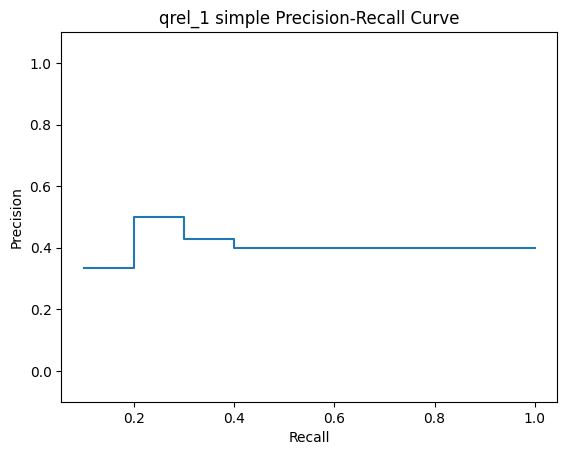

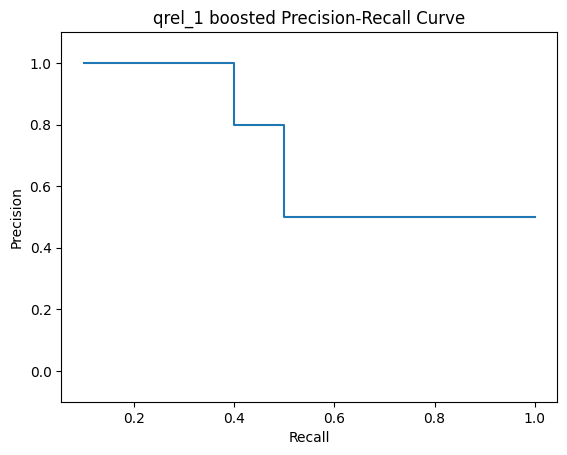

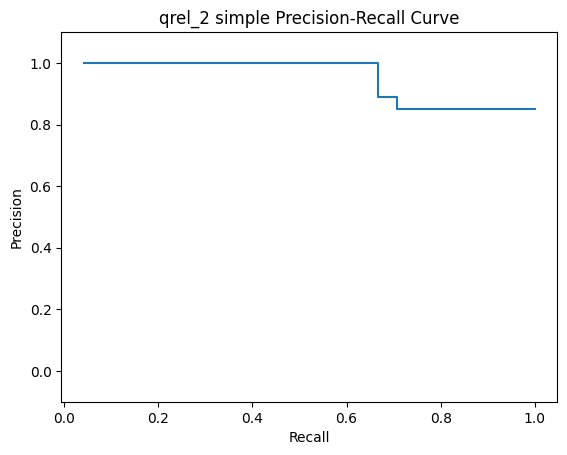

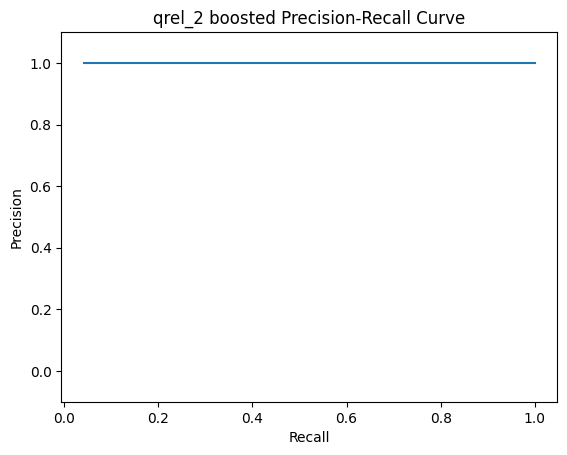

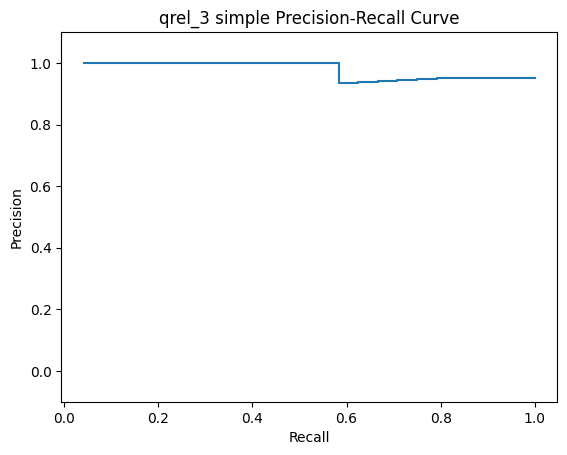

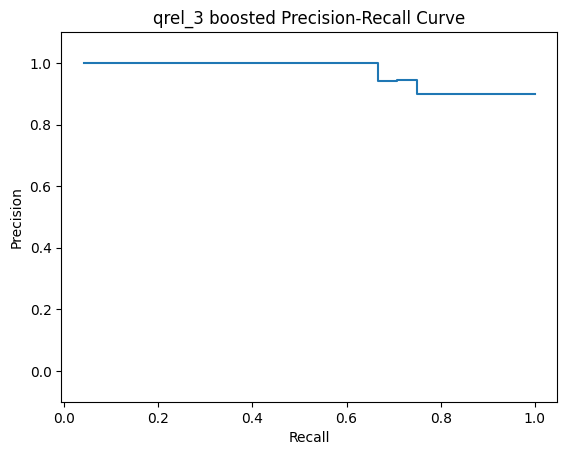

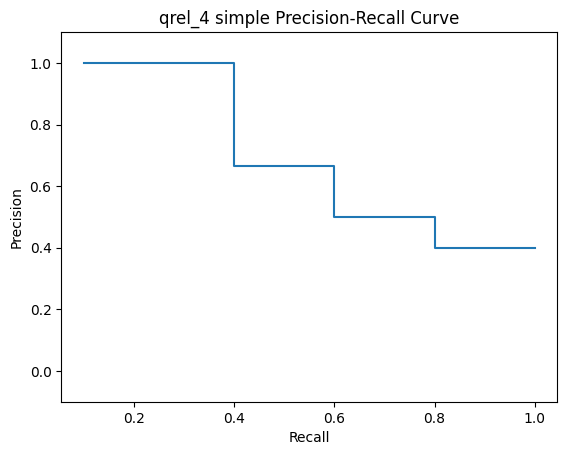

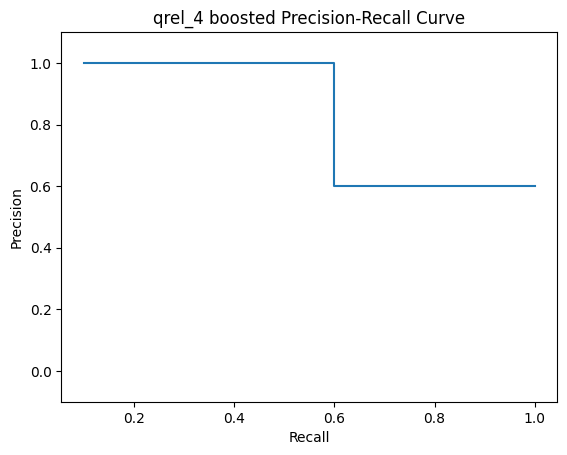

In [16]:
for query_name, query_info in info.items():
    # Read qrels to extract relevant documents
    relevant = list(map(lambda el: el.strip(), open(query_info["qrels_file"]).readlines()))

    # Get query results from Solr instance for both simple and boosted queries
    simple_results = requests.get(query_info["simple_query_url"]).json()['response']['docs']
    boosted_results = requests.get(query_info["boosted_query_url"]).json()['response']['docs']

    # Calculate precision-recall values for both simple and boosted queries
    simple_precision_recall_match, recall_values_simple = calculate_precision_recall(simple_results, relevant)
    boosted_precision_recall_match, recall_values_boosted = calculate_precision_recall(boosted_results, relevant)

    # Generate plots for both simple and boosted queries
    generate_plots(simple_precision_recall_match, recall_values_simple, query_name, "simple")
    generate_plots(boosted_precision_recall_match, recall_values_boosted, query_name, "boosted")

    # Calculate metrics for both simple and boosted queries and export results as LaTeX tables
    df_simple_metrics = calculate_metrics(simple_results, relevant)
    df_boosted_metrics = calculate_metrics(boosted_results, relevant)

    with open(f'./results-tex/{query_name}_simple_results.tex','w') as tf_simple:
        tf_simple.write(df_simple_metrics.to_latex())

    with open(f'./results-tex/{query_name}_boosted_results.tex','w') as tf_boosted:
        tf_boosted.write(df_boosted_metrics.to_latex())